In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import FastText
from sklearn.metrics import confusion_matrix

In [3]:
def preprocess_data(file_path):
    texts = []
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            text, emotion = line.strip().split(';')
            texts.append(text)
            labels.append(emotion)
    return texts, labels

In [9]:
train_texts, train_labels = preprocess_data('/Users/karpagapriyadhanraj/Desktop/EPITA/Action_learning/Sentiment-Analysis/data/train.txt')
test_texts, test_labels = preprocess_data('/Users/karpagapriyadhanraj/Desktop/EPITA/Action_learning/Sentiment-Analysis/data/test.txt')

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

In [11]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)


In [12]:
max_sequence_length = max(len(seq) for seq in train_sequences)
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)

In [13]:
fasttext_model = FastText(sentences=[text.split() for text in train_texts], window=5, min_count=1, workers=4, sg=1)



In [14]:
train_vectors = np.array([np.mean([fasttext_model.wv[word] for word in text.split() if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for text in train_texts])
test_vectors = np.array([np.mean([fasttext_model.wv[word] for word in text.split() if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for text in test_texts])


In [15]:
label_dict = {
    "sadness": 0,
    "joy": 1,
    "anger": 2,
    "fear": 3,
    "love": 4,
    "surprise": 5
}
train_labels_numeric = np.array([label_dict[label] for label in train_labels])
test_labels_numeric = np.array([label_dict[label] for label in test_labels])

## SVM

##### Reference:
##### 1. https://www.youtube.com/watch?v=T9UcK-TxQGw
##### 2. https://medium.com/@gallettilance/support-vector-machines-16241417ee6d

In [16]:
np.random.seed(42)
input_dim = train_vectors.shape[1]
w = np.random.randn(input_dim)
b = np.random.randn()

In [17]:
epochs = 100
lr = 0.10
expanding_rate = 1
retracting_rate = 2

In [18]:
for _ in range(epochs):
    i = np.random.randint(0, len(train_vectors))
    x, y = train_vectors[i], train_labels_numeric[i]
    y = 1 if y > 2 else -1 

    ypred = np.dot(w, x) + b
    if (ypred > 0 and y > 0) or (ypred < 0 and y < 0):
        if ypred < 1 and ypred > -1:
            w = w + x * y * lr * retracting_rate
            b = b + y * lr * retracting_rate
        else:
            w = w * expanding_rate
            b = b * expanding_rate
    else:
        w = w + x * y * lr * expanding_rate
        b = b + y * lr * expanding_rate


In [19]:
def predict(x):
    ypred = np.dot(w, x) + b
    return 1 if ypred > 0 else 0

In [20]:
predictions = np.array([predict(x) for x in test_vectors])
test_labels_binary = np.array([1 if y > 2 else 0 for y in test_labels_numeric])

In [21]:
accuracy = np.mean(predictions == test_labels_binary)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 77.45%


In [22]:
cm = confusion_matrix(test_labels_binary, predictions)

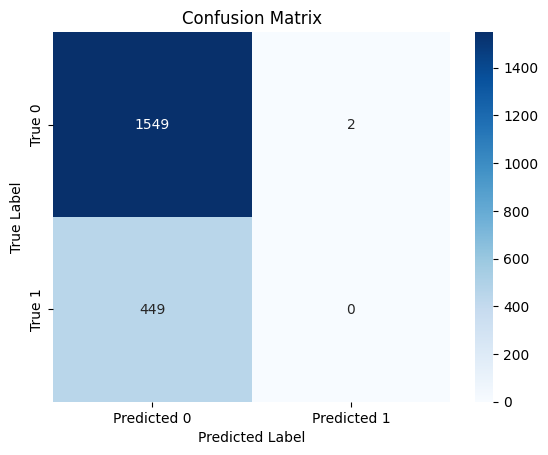

In [23]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
svm_model = {'w': w, 'b': b}
joblib.dump(svm_model, 'svm_model.joblib')

['svm_model.joblib']